In [1]:
import torch
import torchvision
from collections import namedtuple
import os
import matplotlib.pyplot as plt
from attacks.analytic_attack import ImprintAttacker
from modifications.imprint import ImprintBlock
from utils.breaching_utils import *

import medmnist
from medmnist import INFO, Evaluator

from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
from torch.utils.data import DataLoader

In [ ]:
batch_size = 1 # Number of images in the user's batch. We have a small one here for visualization purposes
import random
random.seed(234324) # You can change this to get a new batch.

transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=data_cfg_default.mean, std=data_cfg_default.std),
    ]
)
data_flag = 'dermamnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
dataset = DataClass(split="val", transform=transforms, download=True, size=224)
samples = [dataset[i] for i in random.sample(range(len(dataset)), batch_size)]
data = torch.stack([sample[0] for sample in samples])
labels = torch.tensor([sample[1] for sample in samples]).flatten()

### Initialize your model

In [3]:
setup = dict(device=torch.device("cpu"), dtype=torch.float)

# This could be any model:
model = torchvision.models.resnet18(pretrained = True)
# Modify the final layer to have 7 output classes
model.fc = torch.nn.Linear(512, 7)

loss_fn = torch.nn.CrossEntropyLoss()


/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# #add opacus here -> problem with the model structure (ImprintBlock) so do it after the imprint block
# model = ModuleValidator.fix(model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  
training_set = DataClass(split="train", transform=transforms, download=True, size=224)
training_loader = DataLoader(training_set, batch_size=batch_size)

# #if hasattr(model, "autograd_grad_sample_hooks"):
# #    del model.autograd_grad_sample_hooks

# privacy_engine = PrivacyEngine()
# model, optimizer, data_loader = privacy_engine.make_private(
#     module=model,
#     optimizer=optimizer,
#     data_loader=training_loader, 
#     noise_multiplier=1.1,
#     max_grad_norm=1,
#     poisson_sampling= False,
#     grad_sample_mode= "hooks",
#     #grad_sample_mode="ew",
# )

In [5]:
# It will be modified maliciously:
input_dim = data_cfg_default.shape[0] * data_cfg_default.shape[1] * data_cfg_default.shape[2]
num_bins = 100 # Here we define number of imprint bins
block = ImprintBlock(input_dim, num_bins=num_bins)
model = torch.nn.Sequential(
    torch.nn.Flatten(), block, torch.nn.Unflatten(dim=1, unflattened_size=data_cfg_default.shape), model
)
secret = dict(weight_idx=0, bias_idx=1, shape=tuple(data_cfg_default.shape), structure=block.structure)
secrets = {"ImprintBlock": secret}

In [6]:
# Model training

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in training_loader:
        labels = labels.flatten()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(training_loader)}")

print("Training finished")


Epoch 1, Loss: 1.2365705210081404
Epoch 2, Loss: 1.1891924668556957
Epoch 3, Loss: 1.1836546168009872
Epoch 4, Loss: 1.1810608394683233
Epoch 5, Loss: 1.1797050459152778
Epoch 6, Loss: 1.178737082174259
Epoch 7, Loss: 1.1778147047569258
Epoch 8, Loss: 1.1767004272584587
Epoch 9, Loss: 1.1756451770384675
Epoch 10, Loss: 1.1746635802639898
Training finished


In [9]:
model_trained = model

#model_trained = model._modules["3"]
print(model_trained(data))

tensor([[-0.5517, -0.0894,  1.1402, -2.1113,  0.8600,  2.5012, -1.5092]],
       grad_fn=<AddmmBackward0>)


### Simulate an attacked FL protocol

In [10]:

# This is the attacker:
attacker = ImprintAttacker(model_trained, loss_fn, attack_cfg_default, setup)

#Server-side computation:

queries = [dict(parameters=[p for p in model_trained.parameters()], buffers=[b for b in model_trained.buffers()])]
server_payload = dict(queries=queries, data=data_cfg_default)

#User-side computation:
#labels_expanded = labels.repeat(2)  # Adjust 2 to match the actual batch size of data


loss = loss_fn(model_trained(data), labels)



In [11]:
print(model_trained(data))
print(labels)

tensor([[-0.5517, -0.0894,  1.1402, -2.1113,  0.8600,  2.5012, -1.5092]],
       grad_fn=<AddmmBackward0>)
tensor([5])


In [12]:
shared_data = dict(
    gradients=[torch.autograd.grad(loss, model_trained.parameters())],
    buffers=None,
    num_data_points=1,
    labels=labels,
    local_hyperparams=None,
)

### Reconstruct data from the update

In [13]:
# Attack:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, secrets, dryrun=False)

Initially produced 2 hits.
Reduced to 1 hits.


In [14]:
# Metrics?: 
from utils.analysis import report
true_user_data = {'data': data, 'labels': labels}
metrics = report(reconstructed_user_data,
    true_user_data,
    server_payload,
    model, compute_ssim=False) # Can change to true and install a package...
print(f"MSE: {metrics['mse']}, PSNR: {metrics['psnr']}, LPIPS: {metrics['lpips']}, SSIM: {metrics['ssim']} ")

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MSE: 2.0049627203533912e-17, PSNR: 166.9789276123047, LPIPS: 1.0593144471413712e-13, SSIM: 0 


### Plot ground-truth data

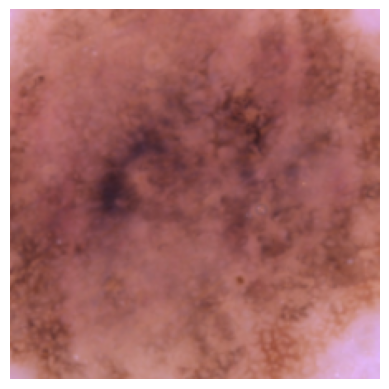

In [15]:
plot_data(data_cfg_default, true_user_data, setup)

# Create the "images" folder if it doesn't exist
if not os.path.exists("images"):
    os.makedirs("images")

# Save the images inside the "images" folder
plt.savefig("images/true_user_data.png")


### Now plot reconstructed data

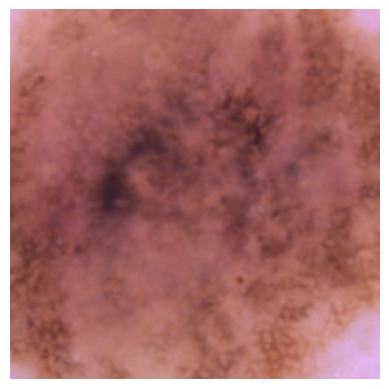

In [16]:
plot_data(data_cfg_default, reconstructed_user_data, setup)
# Save the images inside the "images" folder
plt.savefig("images/reconstructed_user_data.png")